# **Part 3: Instance Segmentation - Optimized Mask-RCNN**
In this notebook, I try to optimize the Mask-RCNN model by adding LSTMs.

In [ ]:
import torch
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import DataLoader
from torchvision import transforms
import os

from models.mask_rcnn import visualize_mask_rcnn_predictions
from models.mask_rcnn_opt import create_opt_mask_rcnn_model
from models.mask_rcnn_utils import evaluate_maskrcnn_model

from custom_dataset import MaskRCNNSegmentationDataset
from training import train_mask_rcnn
from utils import load_weights

In [2]:
# Checking CUDA availability and setting the device accordingly
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device = }")

device = 'cpu'


## **Instance Segmentation**

#### **Initializating & Visualizing Dataloaders**

In [3]:
def collate_fn(batch):
    images, targets = zip(*batch)
    images = list(images)
    targets = [{k: v for k, v in t.items()} for t in targets]

    return images, targets

data_folder = './Data/lums_instance_segmentation_data'

# defining transform
resize = 256
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((resize, resize)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creating training and testing datasets
annotation_file = "annotations.json"
train_dataset_mrcnn = MaskRCNNSegmentationDataset(data_folder=data_folder, annotation_file=annotation_file, transforms=transform)
test_dataset_mrcnn = MaskRCNNSegmentationDataset(data_folder=data_folder, annotation_file=annotation_file, transforms=transform)

# Creating training and testing dataloaders
BATCH_SIZE = 4
train_loader_mrcnn = DataLoader(train_dataset_mrcnn, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader_mrcnn = DataLoader(test_dataset_mrcnn, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


### **Initializing Optimized MaskRCNN Model**

Next, we wanted to optimize our model to predict better masks and higher leaf count accuracy.

In [ ]:
opt_mask_rcnn_model = create_opt_mask_rcnn_model(2, device)
weights_path_mrcnn_lstm = "./weights/Mask_RCNN_LSTM.pth"
    
if os.path.exists(weights_path_mrcnn_lstm):
    load_weights(opt_mask_rcnn_model, weights_path_mrcnn_lstm, device)

params = [p for p in opt_mask_rcnn_model.parameters() if p.requires_grad]
optimizer_mrcnn = optim.Adam(params=params, lr=0.0001)
scaler = torch.cuda.amp.GradScaler()
epochs_mrcnn = 30

if False:
    losses = train_mask_rcnn(opt_mask_rcnn_model, train_loader_mrcnn, optimizer_mrcnn, scaler, epochs_mrcnn, device, weights_path_mrcnn_lstm)

load_weights(opt_mask_rcnn_model, weights_path_mrcnn_lstm, device)

C:\Users\haroo\AppData\Local\Temp\ipykernel_39444\1444594828.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
C:\Users\haroo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\amp\grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
C:\Users\haroo\AppData\Local\Temp\ipykernel_39444\1444594828.py:15: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [5]:
input_size = (1, 3, 224, 224)
model_summary = summary(opt_mask_rcnn_model, input_size=input_size)
print(model_summary)

Layer (type:depth-idx)                             Output Shape              Param #
MaskRCNN                                           [1, 4]                    --
├─GeneralizedRCNNTransform: 1-1                    [1, 3, 800, 800]          --
├─BackboneWithFPN: 1-2                             [1, 256, 13, 13]          --
│    └─IntermediateLayerGetter: 2-1                [1, 2048, 25, 25]         --
│    │    └─Conv2d: 3-1                            [1, 64, 400, 400]         9,408
│    │    └─BatchNorm2d: 3-2                       [1, 64, 400, 400]         128
│    │    └─ReLU: 3-3                              [1, 64, 400, 400]         --
│    │    └─MaxPool2d: 3-4                         [1, 64, 200, 200]         --
│    │    └─Sequential: 3-5                        [1, 256, 200, 200]        215,808
│    │    └─Sequential: 3-6                        [1, 512, 100, 100]        1,219,584
│    │    └─Sequential: 3-7                        [1, 1024, 50, 50]         7,098,368
│    │    └─

### **Visualization of images, predictions, and score reports**

All metrics faced a minor drop in value but the leaf count accuracy increased by 8%. $\newline$
This can be due to either the model changes or model training. $\newline$
However, the training parameters of the Mask-RCNN and the optimized Mask-RCNN were kept same.

In [8]:
evaluate_maskrcnn_model(opt_mask_rcnn_model, test_loader_mrcnn, device, soft_leaf_acc_threshold=0)

Soft Leaf Count Accuracy (+/- 0): 92.000%
Precison: 0.939
Recall: 0.917
Accuracy: 0.959
Dice: 0.928
mIoU: 0.866


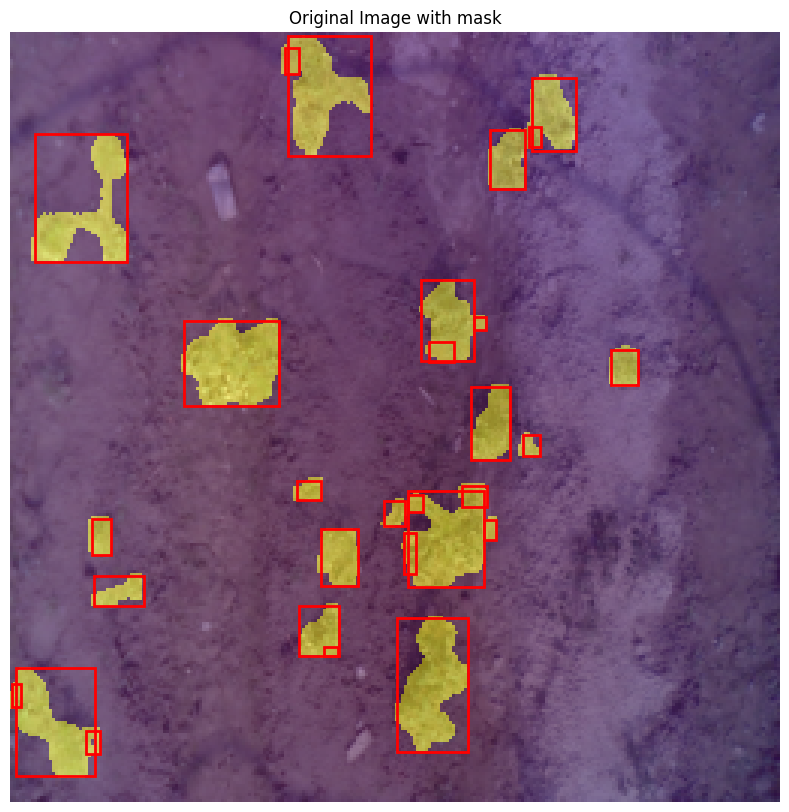

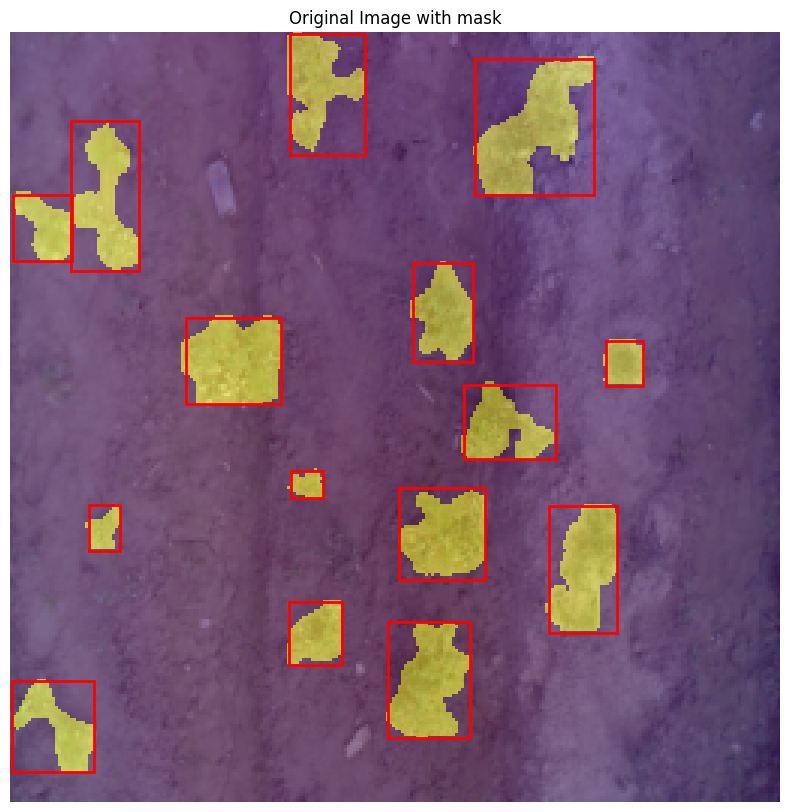

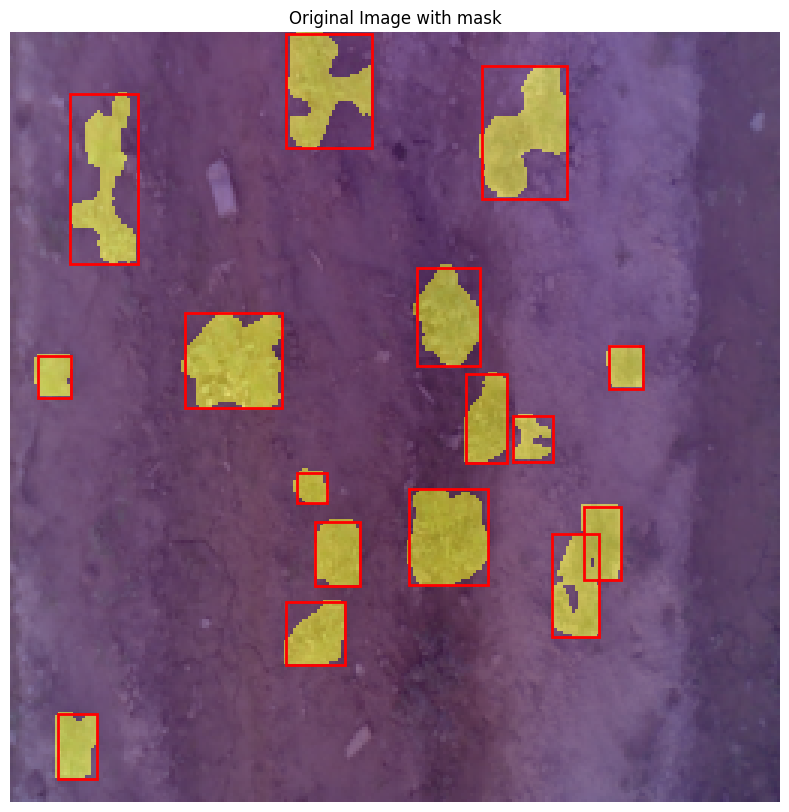

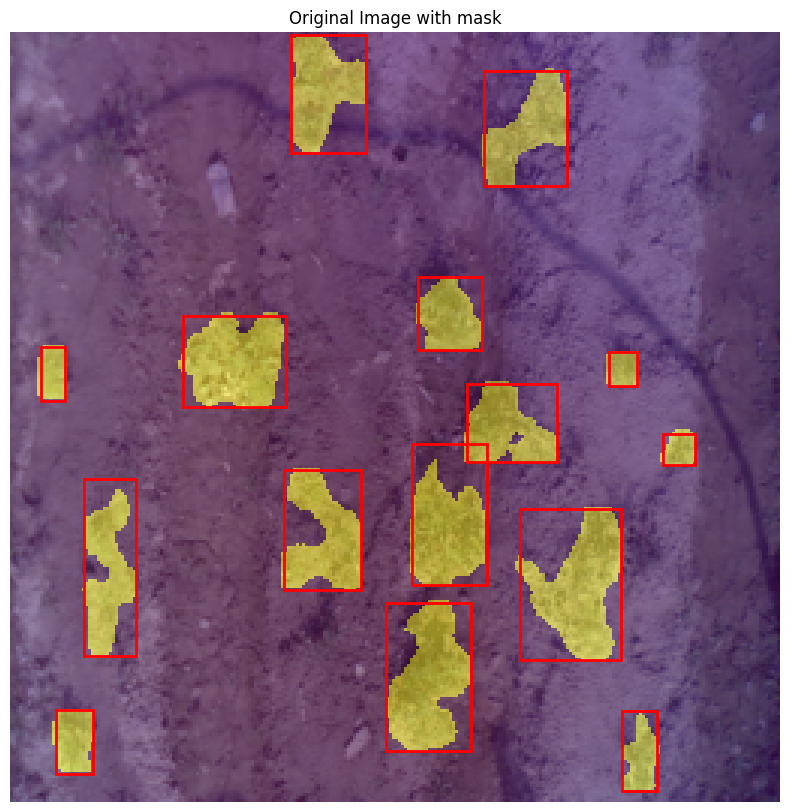

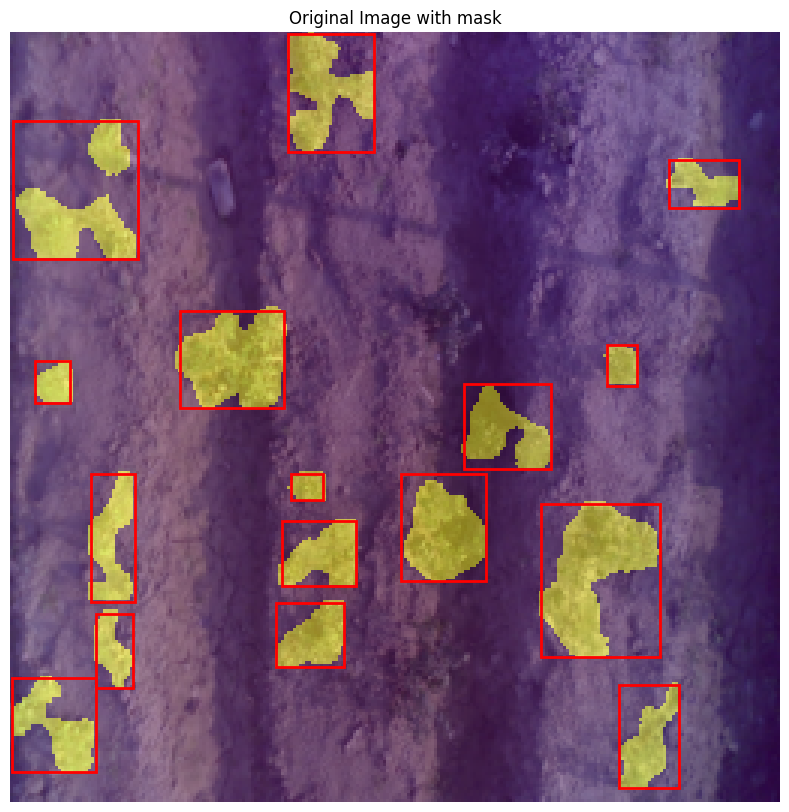

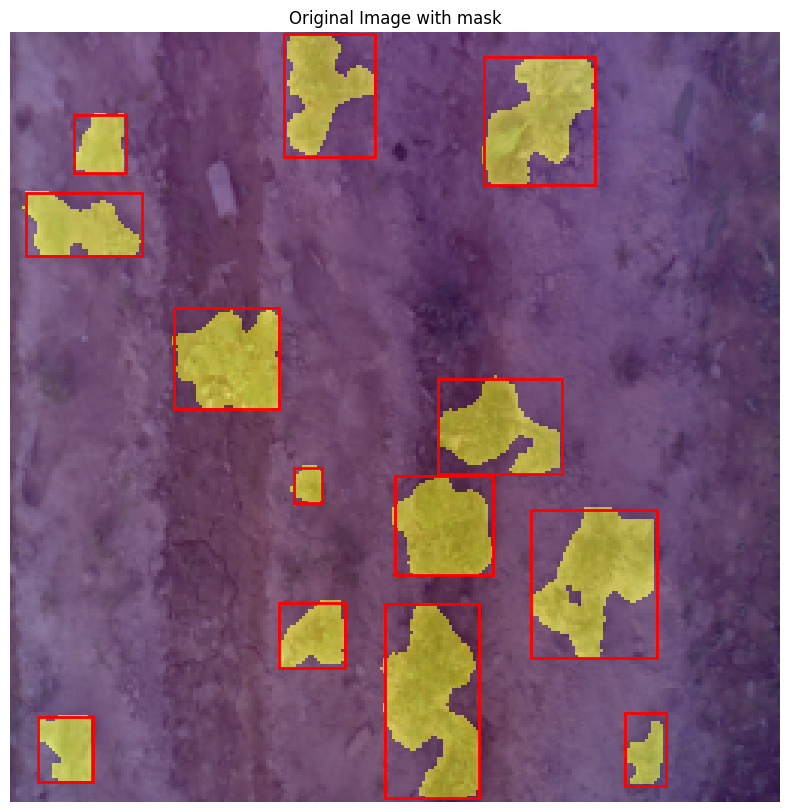

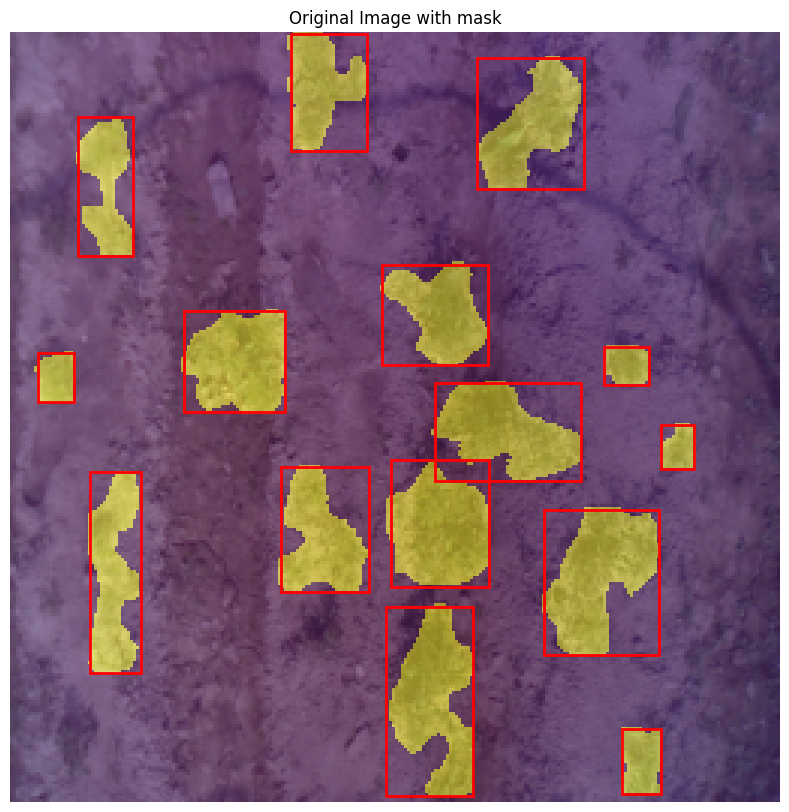

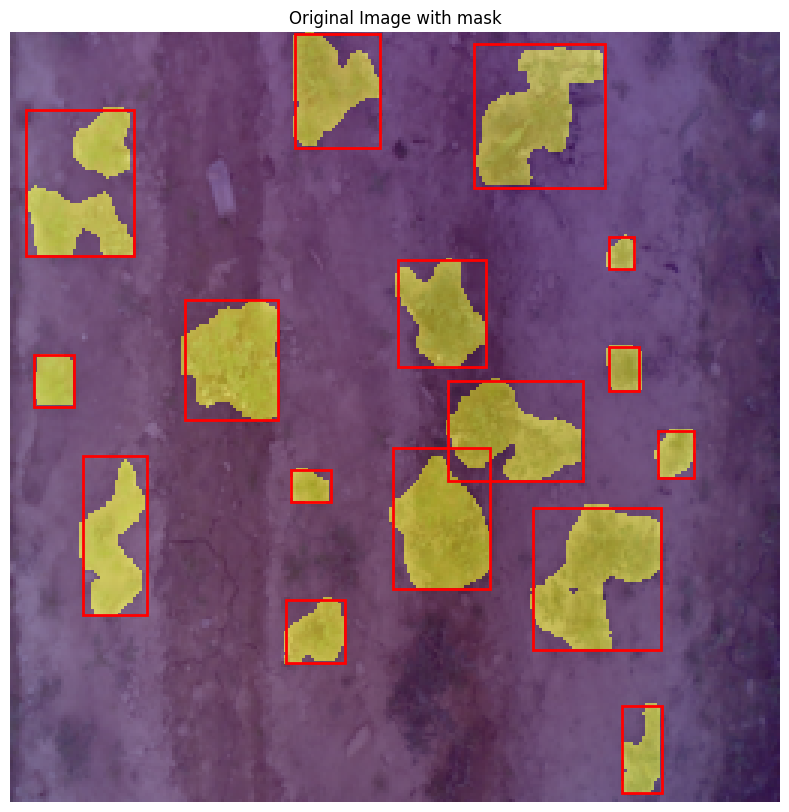

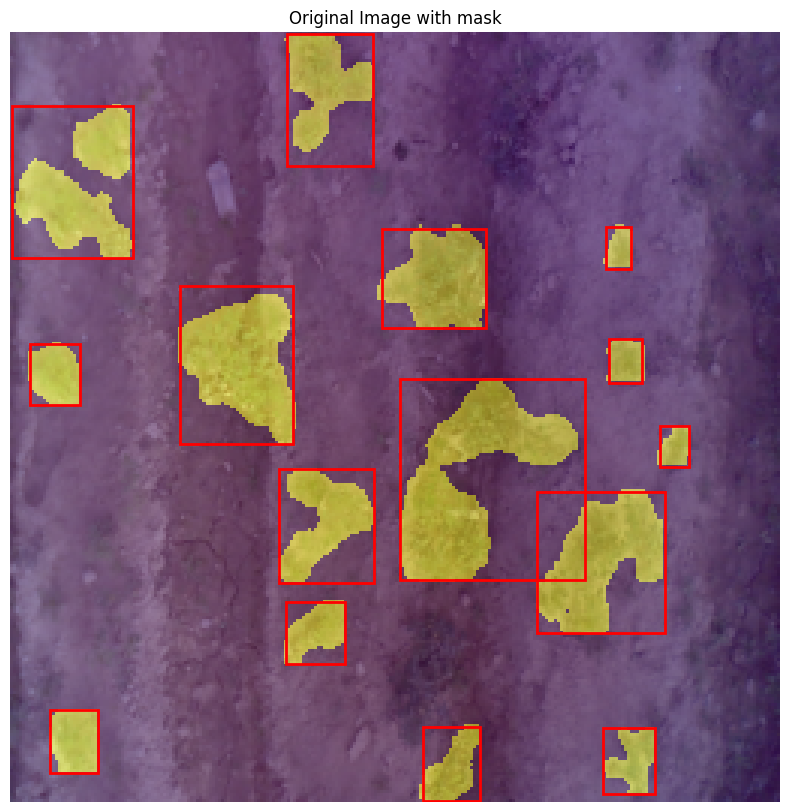

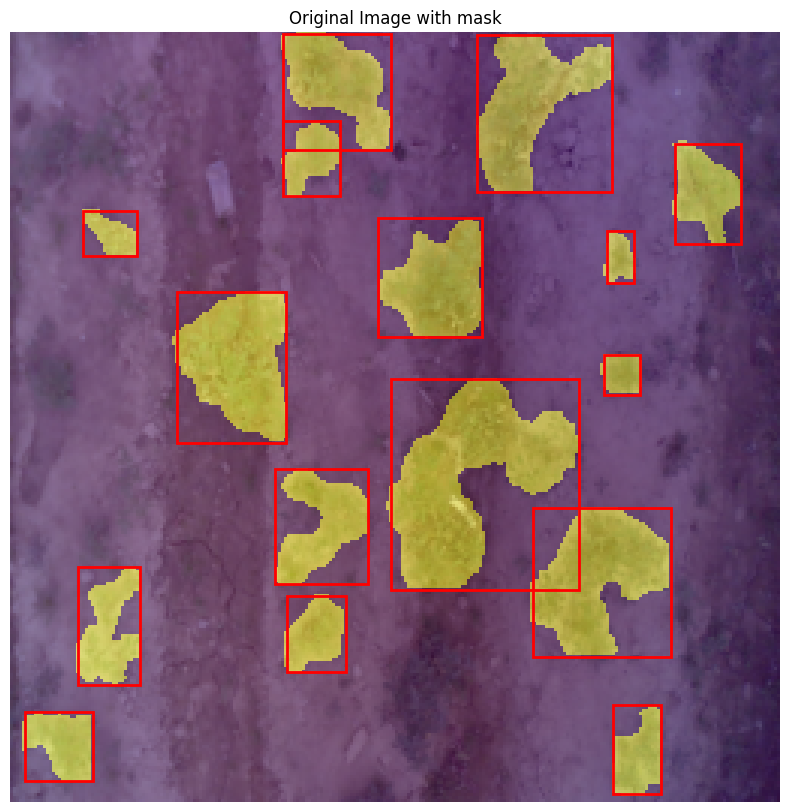

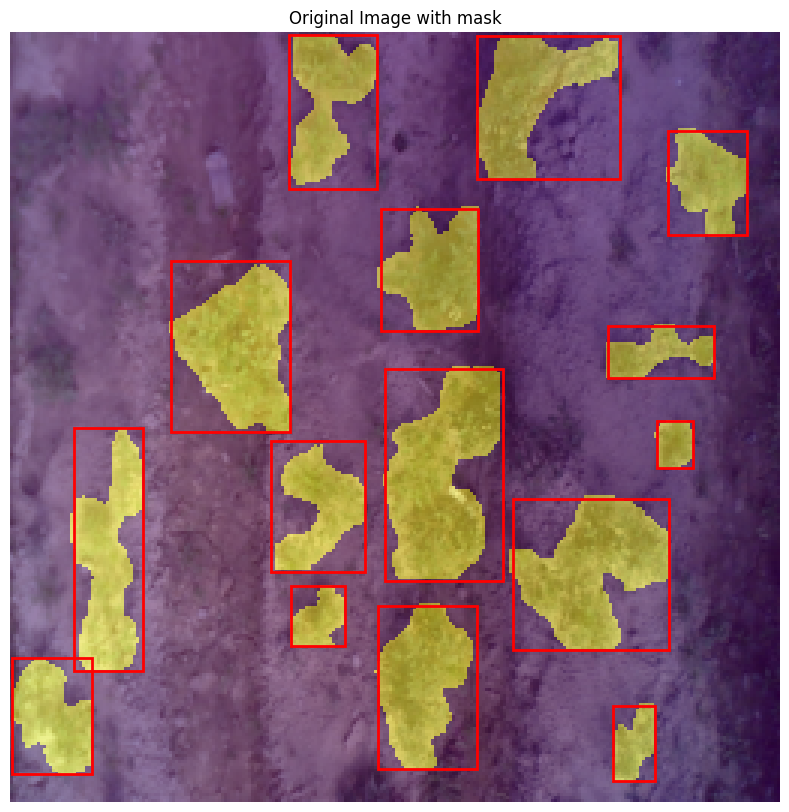

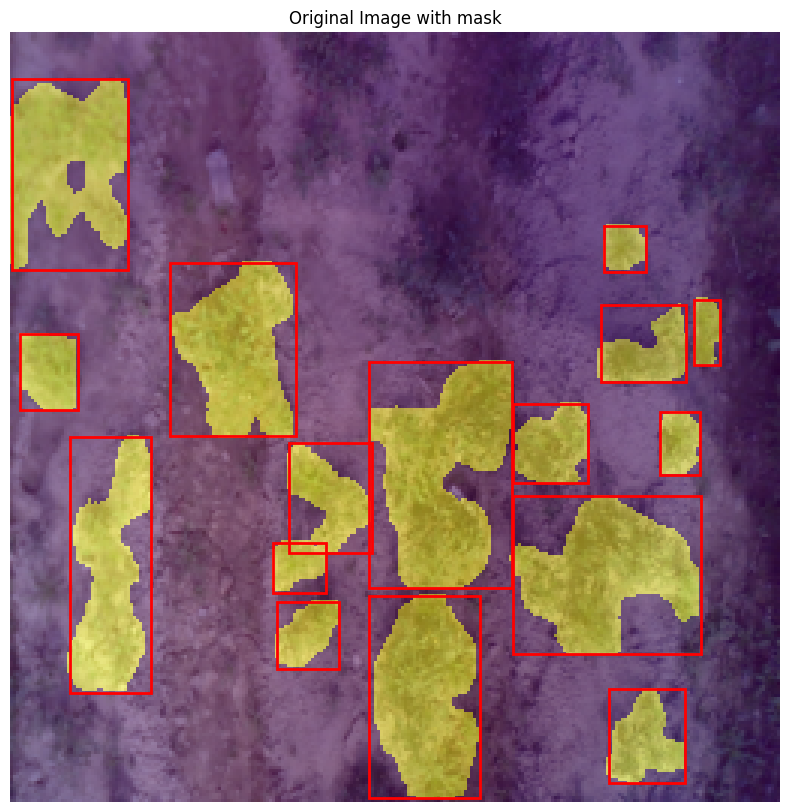

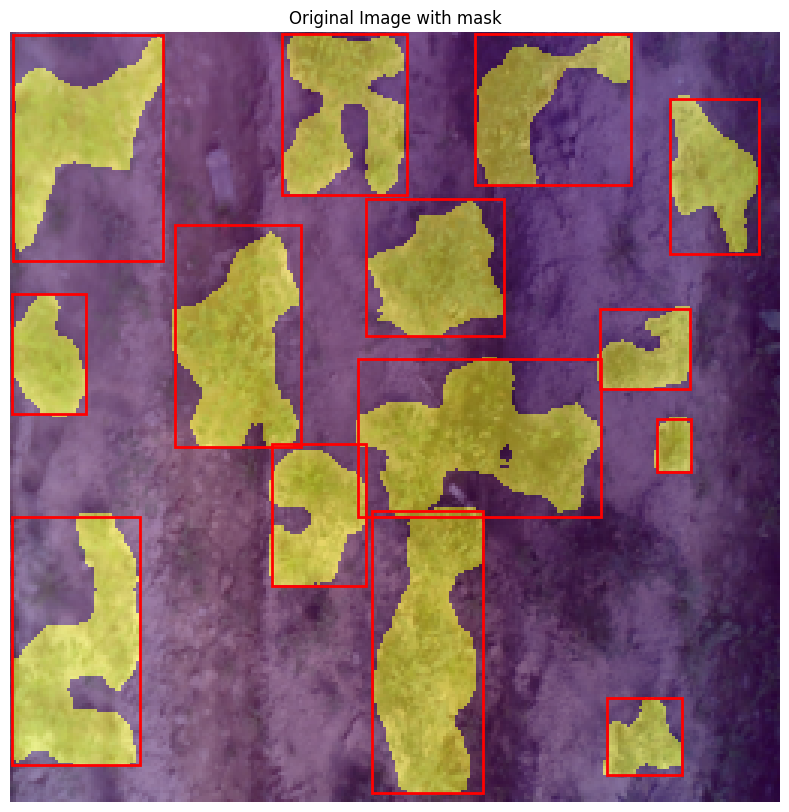

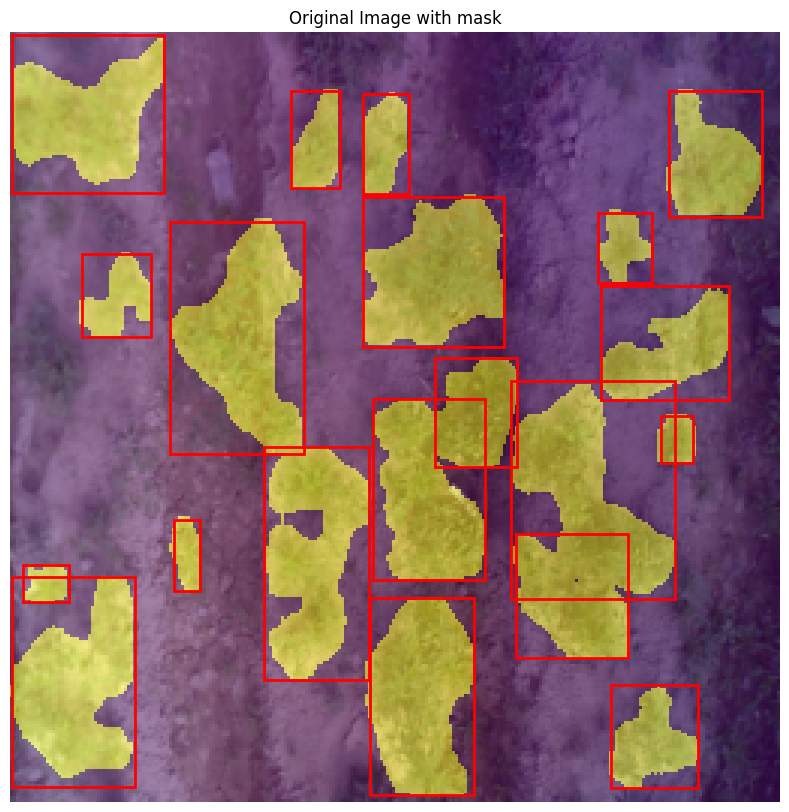

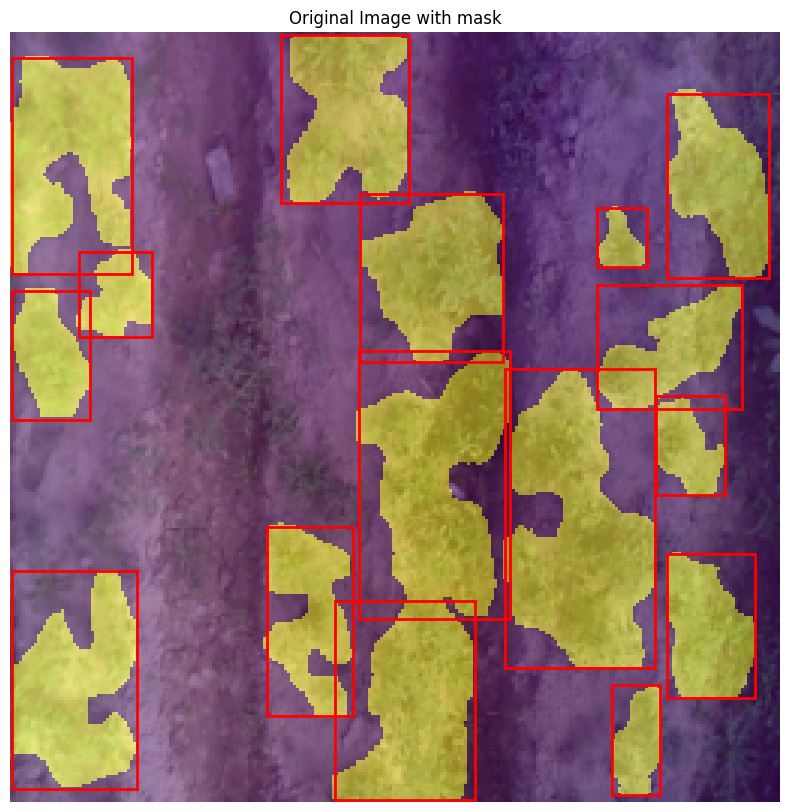

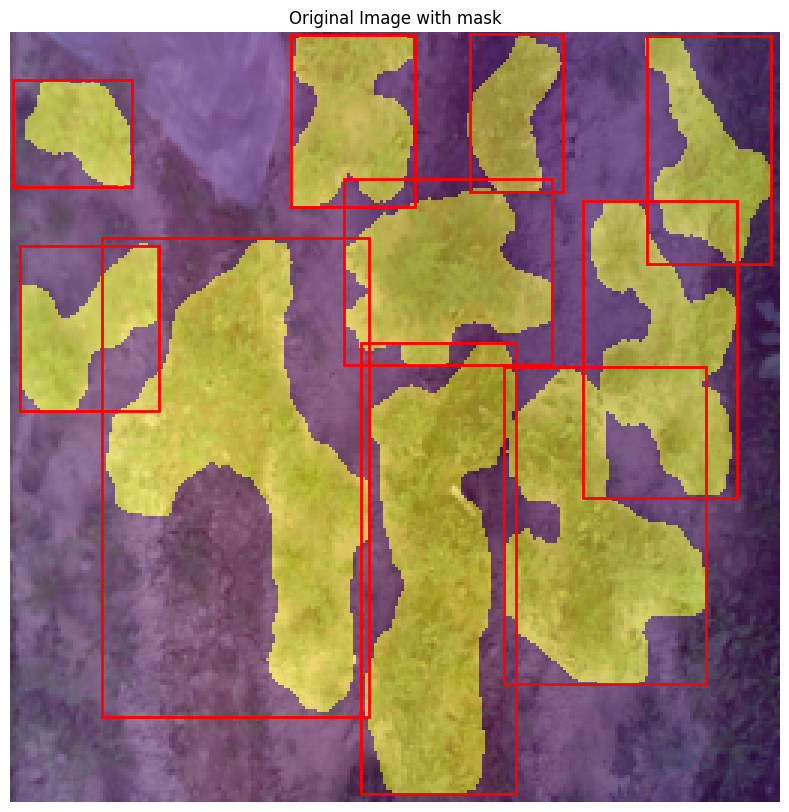

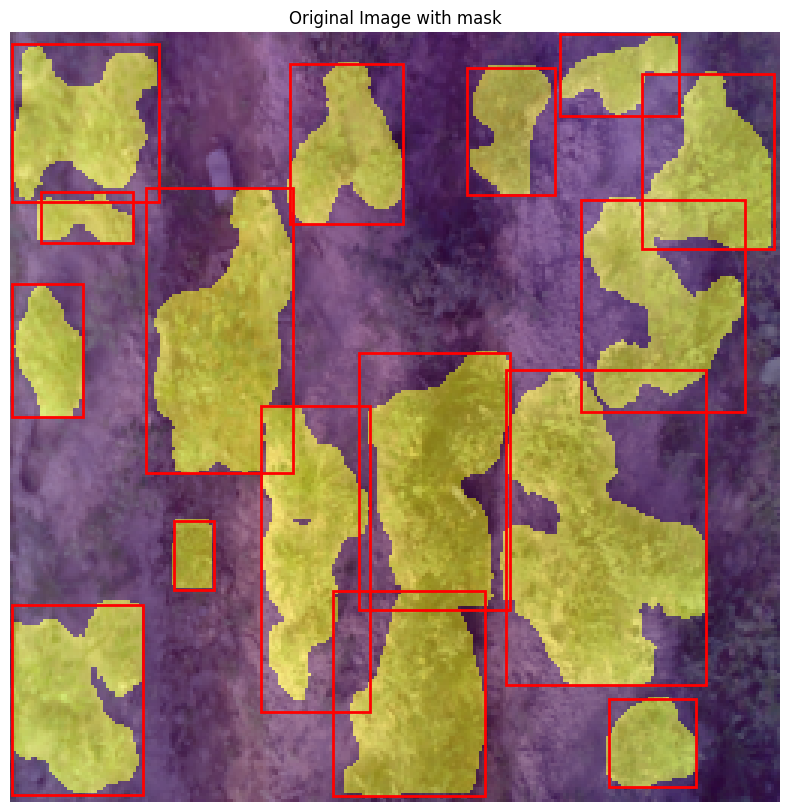

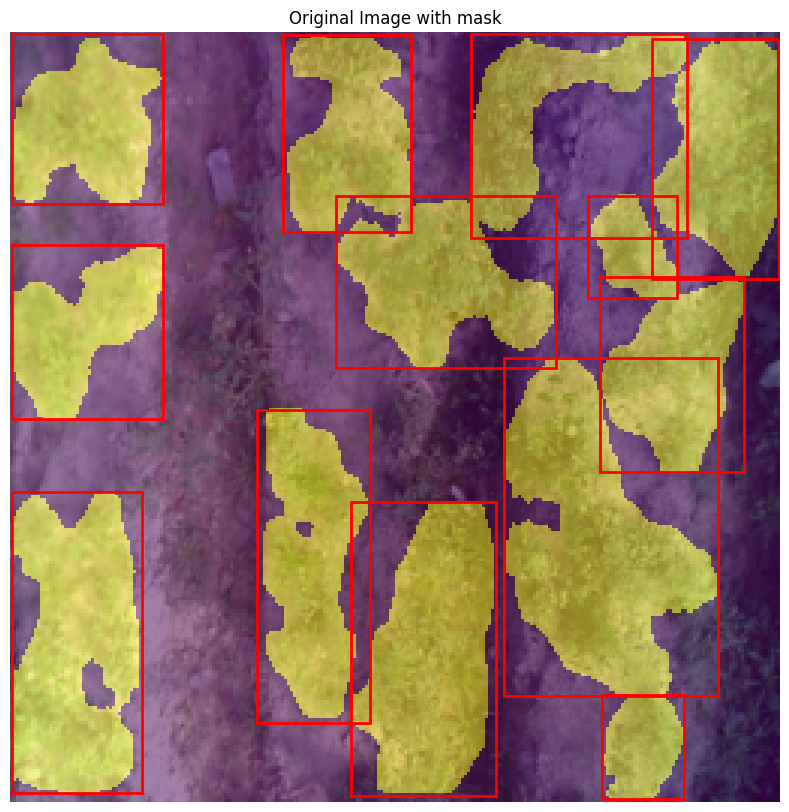

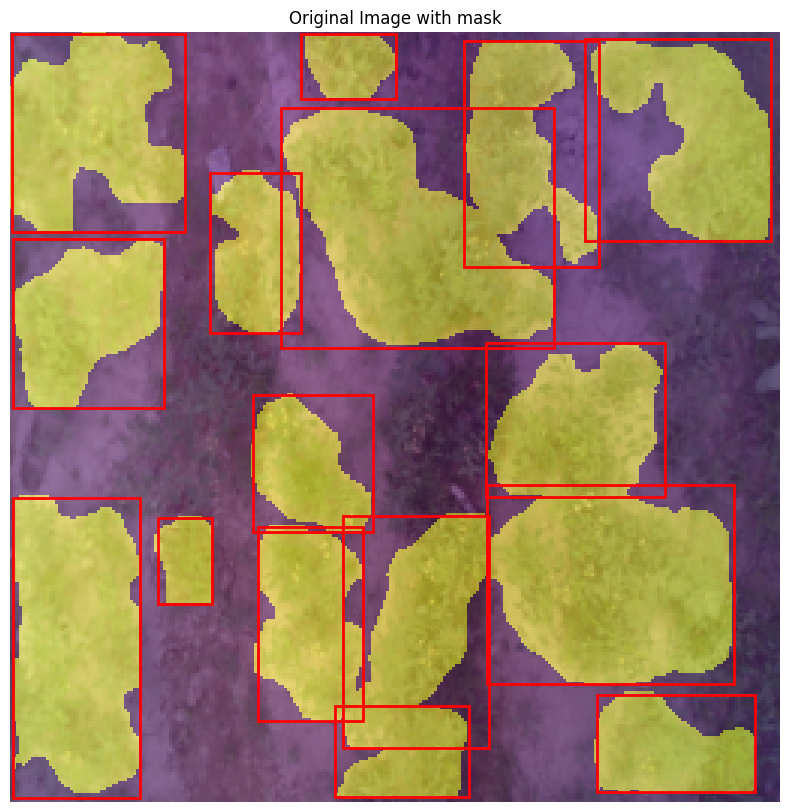

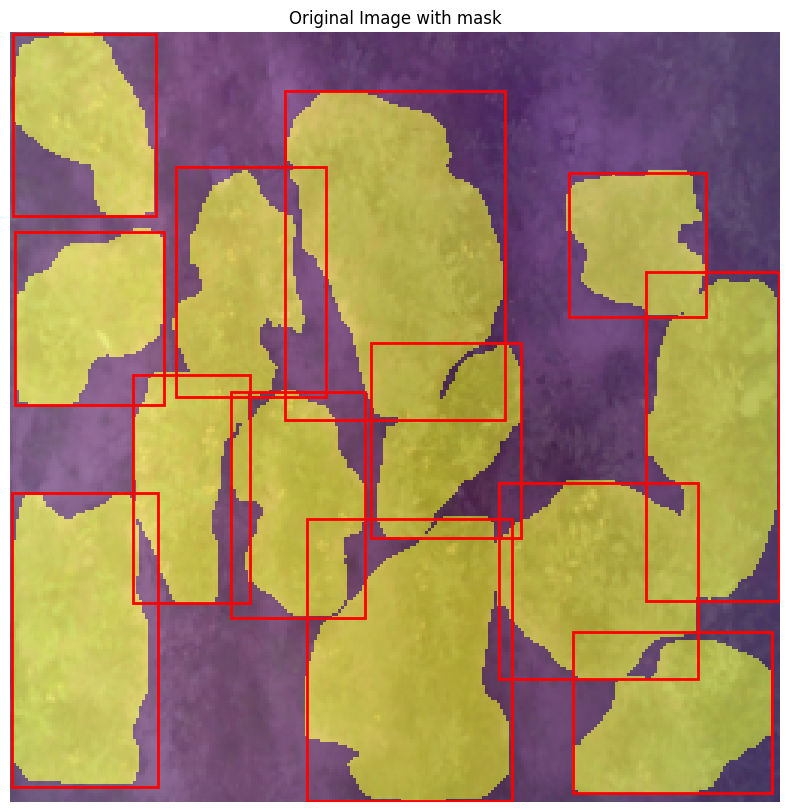

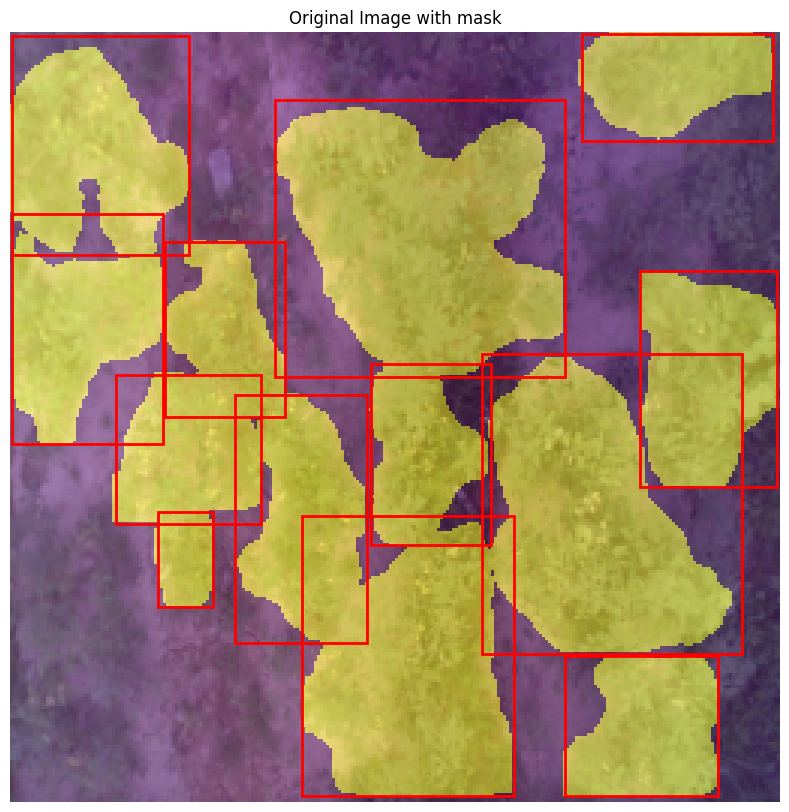

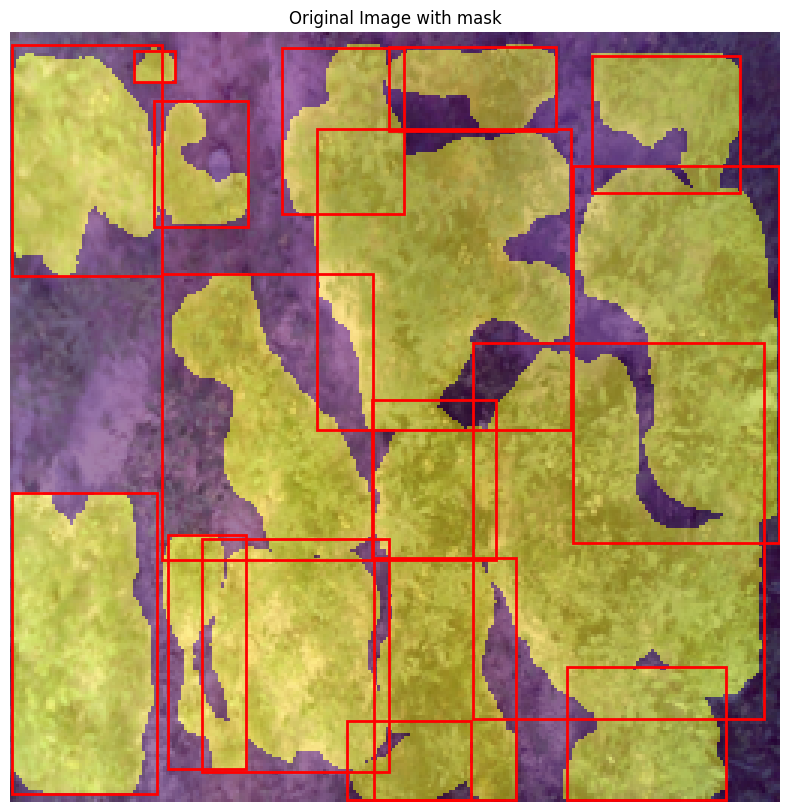

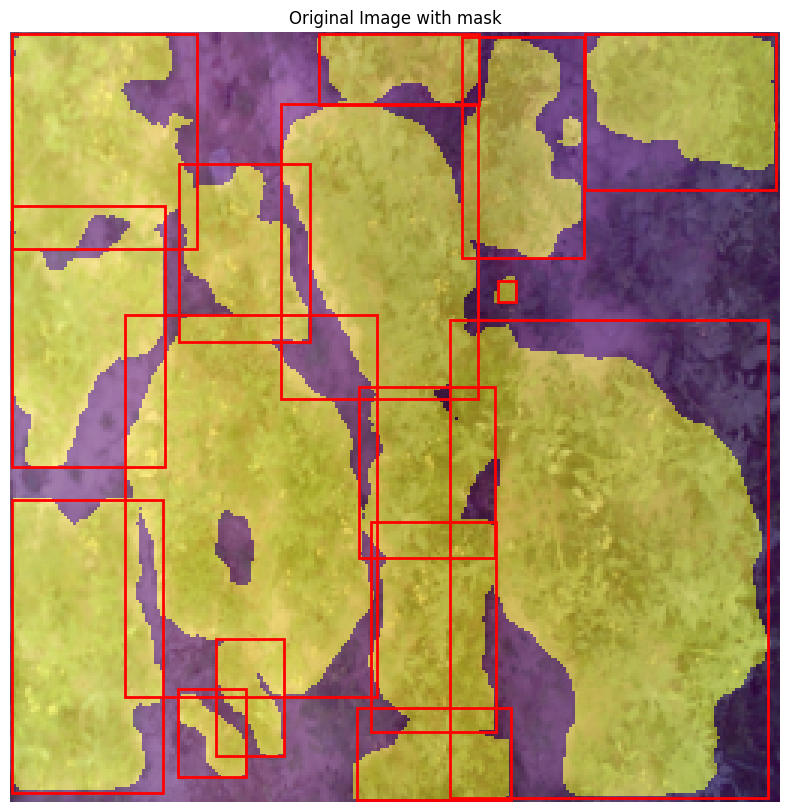

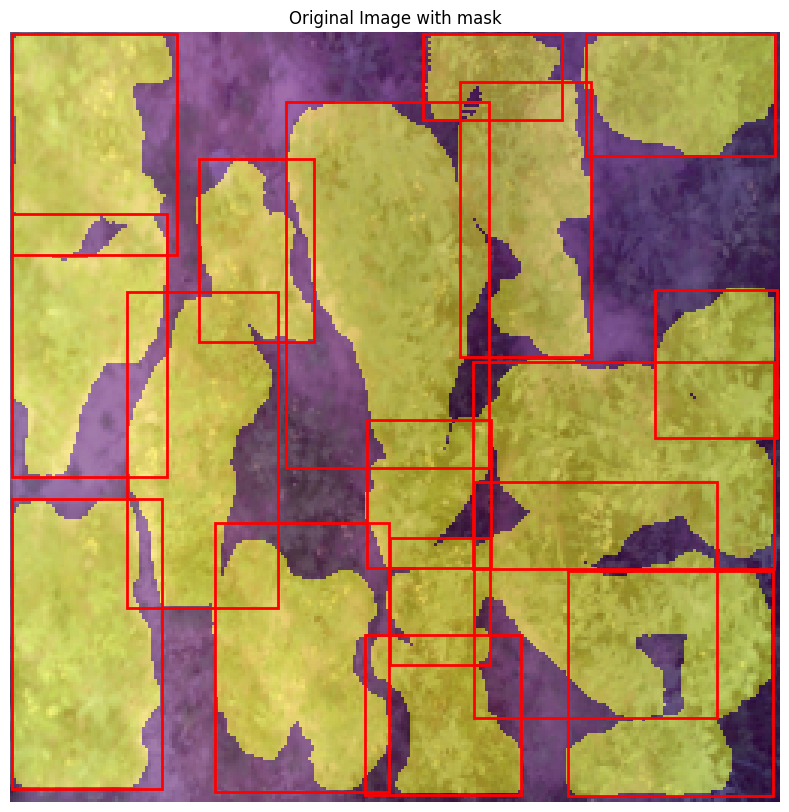

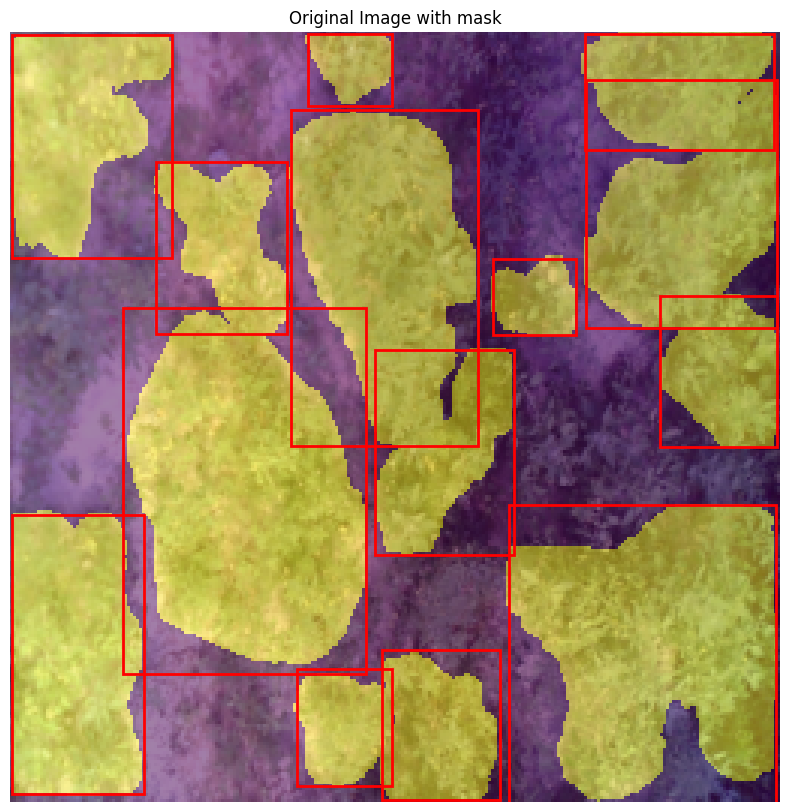

In [7]:
visualize_mask_rcnn_predictions(opt_mask_rcnn_model, test_loader_mrcnn, device)